# Benchmark Analysis
Benchmark data is found under /swann/benchmark

In [4]:
# Imports
import csv
import pandas as pd
import glob
import matplotlib.pyplot as plt

In [5]:
# Helper functions

def csv_to_df(file: str):
    """ Takes in a benchmark file and returns as Pandas DataFrame """
    df = pd.read_csv(
        f'/swann/benchmark/{file}',
        header = 9
    )
    df.dropna(axis=1, inplace=True)
    return df

def get_benchmarks(p=""):
    """ Find all csv files in benchmark folder sorted by date """
    files = glob.glob(f'/swann/benchmark/{p}*.csv')
    files.sort()
    return files

def filter_df_with_wildcard_name(df: pd.DataFrame, name: str):
    """
        Example:
            - name = "LoadDatasets"
        Will return rows where name is "*LoadDatasets*"
    """
    return df.loc[df['name'].str.contains(name)]

def add_empty_time(df: pd.DataFrame, name: str):
    return pd.concat([
        pd.DataFrame(data={
            "name": [f"{name}/-1"],
            "iterations": [1],
            "real_time": [0],
            "cpu_time": [0],
            "time_unit": ["ms"],
            "input_size": [0]
        }),
        df
    ], ignore_index=True)

def prepare_csv(name: str):
    df_bm_query = csv_to_df(name)

    df_query = filter_df_with_wildcard_name(df_bm_query, "QueryXPointsLSHForest")

    # Set input size
    df_query.at[0, 'input_size'] = "100.000"
    df_query.at[1, 'input_size'] = "300.000"
    df_query.at[2, 'input_size'] = "10.000.000"

    df_query.at[0, 'input_size_val'] = 100_000
    df_query.at[1, 'input_size_val'] = 300_000
    df_query.at[2, 'input_size_val'] = 10_000_000


    # Show in ms
    df_query.at[0, 'timePerQuery'] *= 1_000
    df_query.at[1, 'timePerQuery'] *= 1_000
    df_query.at[2, 'timePerQuery'] *= 1_000
    
    return df_query

def get_dfs_by_size(names, size: int):
    df_queries = [
        prepare_csv(name)
        for name in names
    ]
    return [
        df.loc[size]
        for df in df_queries
    ]


def prepare_csv_buckets(name: str):
    df_bm_query = csv_to_df(name)
    
    df_query = filter_df_with_wildcard_name(df_bm_query, "BucketDistribution")
    
    # Set input size
    for i in range(6):
        df_query.at[i, 'input_size'] = "100.000"
        df_query.at[i, 'input_size_val'] = 100_000
    
    for i in range(6):
        df_query.at[i + 6, 'input_size'] = "300.000"
        df_query.at[i + 6, 'input_size_val'] = 300_000
        
    
    for i in range(6):
        df_query.at[i + 12, 'input_size'] = "10.000.000"
        df_query.at[i + 12, 'input_size_val'] = 10_000_000
        
    
    return df_query
    
def get_dfs_buckets(names):
    return [
        prepare_csv_buckets(name)
        for name in names
    ]

In [6]:
for bm in get_benchmarks('/'):
    print(f'[+] {bm}')

[+] /swann/benchmark/benchmark-1677845278.csv
[+] /swann/benchmark/benchmark-1678891718.csv
[+] /swann/benchmark/benchmark-1678967932.csv
[+] /swann/benchmark/benchmark-1678993398.csv
[+] /swann/benchmark/benchmark-1679483931.csv
[+] /swann/benchmark/benchmark-1679485178.csv
[+] /swann/benchmark/benchmark-1680000149.csv
[+] /swann/benchmark/benchmark-1682457063.csv
[+] /swann/benchmark/benchmark-1683103624.csv
[+] /swann/benchmark/benchmark-1683114035.csv
[+] /swann/benchmark/benchmark-1683447577.csv
[+] /swann/benchmark/benchmark-1683447702.csv
[+] /swann/benchmark/benchmark-1683448043.csv
[+] /swann/benchmark/benchmark-1683448385.csv
[+] /swann/benchmark/benchmark-1683448523.csv
[+] /swann/benchmark/benchmark-1683448641.csv
[+] /swann/benchmark/benchmark-1683448715.csv
[+] /swann/benchmark/benchmark-1683448787.csv
[+] /swann/benchmark/benchmark-1683449112.csv
[+] /swann/benchmark/benchmark-1683449414.csv
[+] /swann/benchmark/benchmark-1683449738.csv
[+] /swann/benchmark/benchmark-168

### How to load a dataset

In [5]:
# Load benchmark that has loading / parsing of datasets of size XS and S
df_bm_loadparse = csv_to_df('hasc/benchmark-optimal.csv')
df_bm_loadparse

,name,iterations,real_time,cpu_time,time_unit,foundPerQuery,kNN,recall,slowestQuery,timePerQuery,trie_count,trie_depth
0,QueryXPointsLSHForest/0/10/90/manual_time,1,14669.7,14689.9,ms,10200.6,10,0.94142,0.009807,0.001467,31,13
1,QueryXPointsLSHForest/1/10/90/manual_time,1,41153.2,41180.0,ms,22331.3,10,0.95326,0.023484,0.004115,54,15
2,QueryXPointsLSHForest/2/10/90/manual_time,1,475854.0,475911.0,ms,173635.0,10,0.93758,0.136457,0.047585,158,19


# Visualize data

### Benchmark Query

In [35]:
def visualize_benchmark_query_size(name: str):
    df_query = prepare_csv(name)

    # Show figures
    plt.bar(df_query['input_size'], df_query['timePerQuery'], color = 'blue', alpha=0.5)
    plt.xlabel("Dataset size")
    plt.ylabel("Avg. query time (ms)")
    plt.title("Average query time compared to dataset size - (10 nn, 90% recall)")
    plt.show()
    
def visualize_benchmark_queries_k_L(names, size: int):
    queries = get_dfs_by_size(names, size)
    
    in_size = queries[0]['input_size']
    
    k_Ls     = [ f'k={int(query["trie_depth"])} \nL={int(query["trie_count"])}' for query in queries ]
    avgTimes = [ query['timePerQuery']                                          for query in queries ]
    
    # Show figures
    plt.bar(k_Ls, avgTimes, color = 'teal')
    plt.xlabel("Depth / Trie count")
    plt.ylabel("Avg. query time (ms)")
    plt.title(f'Average query time compared to k/L - {in_size} points')
    plt.show()
    
def visualize_benchmark_query_looked_at(name: str):
    df_query = prepare_csv(name)
    
    # Show figures
    plt.bar(df_query['input_size'], 100 * df_query['foundPerQuery']/df_query['input_size_val'], color = 'teal')
    plt.xlabel("Input size")
    plt.ylabel("% of total points")
    plt.title('Avg. % of points noted as candidate points')
    plt.show()

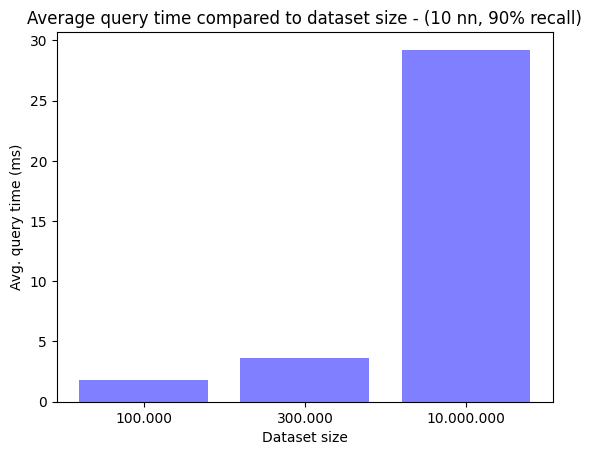

In [36]:
visualize_benchmark_query_size("hasc/benchmark-1683222299.csv")

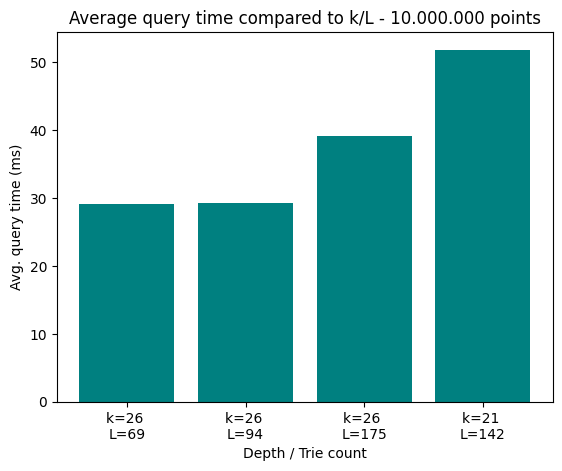

In [8]:
visualize_benchmark_queries_k_L([
    "hasc/benchmark-1683221007.csv",
    "hasc/benchmark-1683222299.csv",
    "hasc/benchmark-1683214436.csv",
    "hasc/benchmark-1683223822.csv"
], 2)

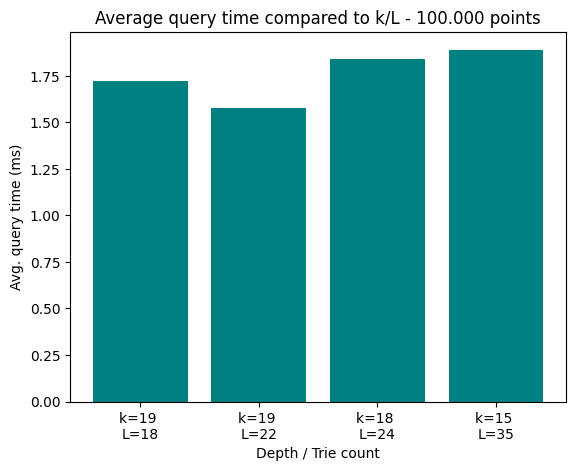

In [9]:
visualize_benchmark_queries_k_L([
    f'hasc/benchmark-{v}.csv'
    for v in [1683217696, 1683218764, 1683222299, 1683223822]
], 0)

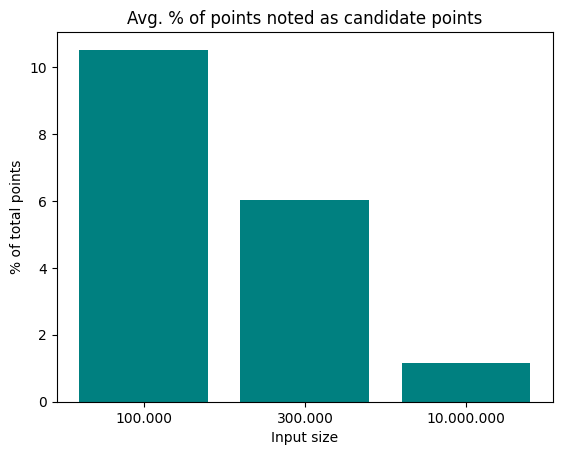

In [10]:
visualize_benchmark_query_looked_at("hasc/benchmark-1683222299.csv")

## Bucket distribution

In [45]:


def visualize_bucket(bucket, insize=90000, tle=""):
    bucketOptimization = bucket[bucket['size'] == insize]
    
    bucketMean = bucketOptimization[bucketOptimization['name'].str.contains("mean")]
    bucketStdDev = bucketOptimization[bucketOptimization['name'].str.contains("stddev")]
        
    # Show figures
    plt.bar(
        [ str(v) for v in bucketMean['optimization']],
        100 * bucketMean['bucketsArrayFactor'],
        yerr=100*bucketStdDev['bucketsArrayFactor'],
        alpha=0.5,
        ecolor='black',
        align='center',
        capsize=10
    )
    plt.xlabel("Optimization steps")
    plt.ylabel("Non-empty buckets (%)")
    
    title = f"Percentage of non-empty buckets{tle}"

    plt.title(title)
    plt.show()
    
def visualize_largest_bucket(bucket, insize=90000, tle=""):
    bucketOptimization = bucket[bucket['size'] == insize]
    
    bucketMean = bucketOptimization[bucketOptimization['name'].str.contains("mean")]
    bucketStdDev = bucketOptimization[bucketOptimization['name'].str.contains("stddev")]
    
    # Show figures
    plt.bar(
        [ str(v) for v in bucketMean['optimization']],
        bucketMean['largestBucket'],
        yerr=bucketStdDev['largestBucket'],
        alpha=0.5,
        ecolor='black',
        color='purple',
        align='center',
        capsize=10
    )
    plt.xlabel("Optimization steps")
    plt.ylabel("Largest bucket count")
    
    title = f"Largest bucket{tle}"

    plt.title(title)
    plt.show()
        

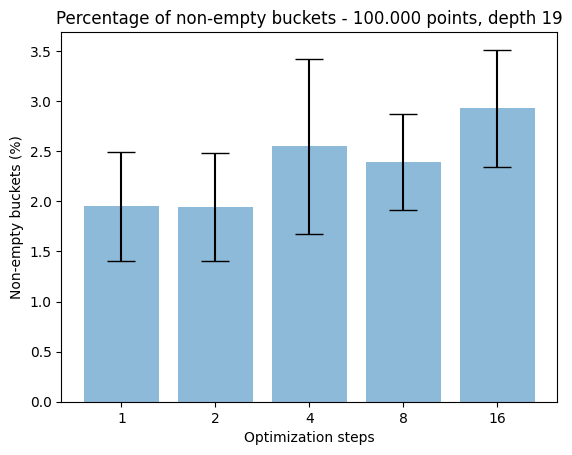

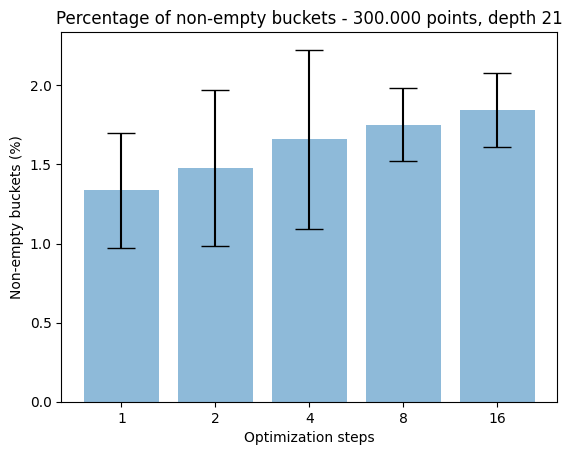

In [79]:
bucket_df = csv_to_df('benchmark-1683802240.csv') # Insert new one
visualize_bucket(bucket_df, 90000, f" - 100.000 points, depth 19")

bucket_df = csv_to_df('hasc/bucket_distribution/benchmark-1683723613.csv')
visualize_bucket(bucket_df, 290000, f" - 300.000 points, depth 21")

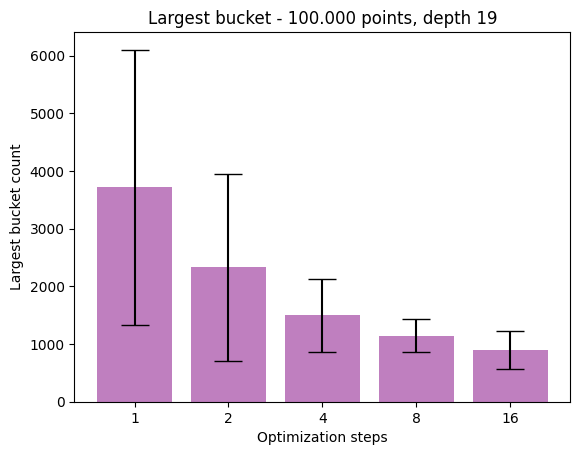

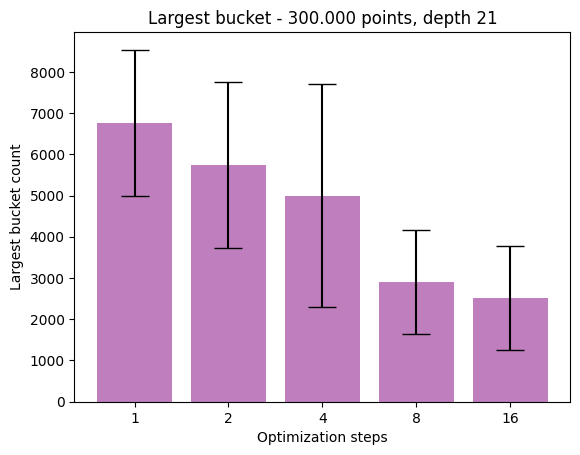

In [46]:
bucket_df = csv_to_df('benchmark-1683802240.csv') # Insert new one
visualize_largest_bucket(bucket_df, 90000, f" - 100.000 points, depth 19")

bucket_df = csv_to_df('hasc/bucket_distribution/benchmark-1683723613.csv')
visualize_largest_bucket(bucket_df, 290000, f" - 300.000 points, depth 21")

# Optimization iterations

In [51]:
def visualize_performance_iterations(dfs, tle=""):
    
    dfs = pd.concat([df for df in dfs])
    
    dfMean = dfs[dfs['name'].str.contains("mean")]
        
    # Show figures
    plt.bar(
        [ str(v) for v in dfMean['optimizationSteps']],
        dfMean['slowestQuery'],
        color='green',
        alpha=0.5,
        ecolor='black',
        align='center',
        capsize=10
    )
    plt.xlabel("Optimization steps")
    plt.ylabel("Slowest query (ms)")
    
    title = f"Slowest query compared to optimization steps{tle}"

    plt.title(title)
    plt.show()

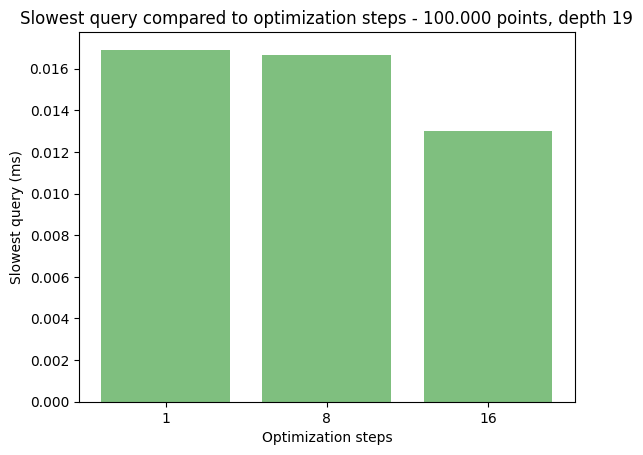

In [52]:
visualize_performance_iterations(
    [
        csv_to_df('benchmark-1683809844.csv'),
        csv_to_df('benchmark-1683810648.csv'),
        csv_to_df('benchmark-1683810009.csv')
    ],
    ' - 100.000 points, depth 19'
)